In [12]:
%load_ext autoreload
%autoreload 2

In [13]:
import matplotlib.pyplot as plt
from ptoa.data.fastmri_dataset import FastSliceDataset
import pandas as pd
import numpy as np
from pathlib import Path
from models.network import Network
import torch
from glob import glob
from torch import nn
from PIL import Image
import torchvision.transforms as T
from tqdm import tqdm

In [34]:
torch. set_grad_enabled(False)
l1 = nn.L1Loss()
l2 = nn.MSELoss()
kl = nn.KLDivLoss()
ce = nn.CrossEntropyLoss()
tx = T.ToTensor()
SMOOTH = 10

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
for ROOT in tqdm(glob('experiments/*colorization*'), position=0):
    ROOT = ROOT + '/results/val/'
    experiment = ROOT.split('/')[-4]
    folders = glob(f"{ROOT}/*")
    folders = sorted(folders, key=lambda f: int(f.split('/')[-1]))
    ret = {}
    for folder in tqdm(folders, position=0):
        epoch = int(folder.split('/')[-1])
        pngs = [g for g in glob(f'{folder}/*') if any(x in g for x in ['GT', 'Out'])]
        slcs = set([p.split('/')[-1].replace('GT_','').replace('Out_','') for p in pngs])
        slcs = {k:
            {'gt': [p for p in pngs if k in p and 'GT' in p][0],
            'out': [p for p in pngs if k in p and 'Out' in p][0]} for k in slcs}
        l1_loss = []
        l2_loss = []
        for slc in slcs.values():
            gt_path = slc['gt']
            gt = Image.open(gt_path)
            gt_array = tx(gt)
            out_path = slc['out']
            out = Image.open(out_path)
            out_array = tx(out)
            l1_loss.append(l1(out_array, gt_array))
            l2_loss.append(l2(out_array, gt_array))
        ret[epoch] = {
            'l1_loss': torch.tensor(l1_loss).mean(),
            'l2_loss': torch.tensor(l2_loss).mean(),
        }
        # print(experiment, epoch, end='\r')

    ax.plot(ret.keys(), pd.Series([r['l1_loss'] for r in ret.values()]).rolling(window=SMOOTH).mean(), label=experiment)
    if ret:
        print(experiment, min([r['l1_loss'] for r in ret.values()]).item(), pd.Series([r['l1_loss'] for r in ret.values()]).rolling(window=SMOOTH).mean().min())    # plt.plot(ret.keys(), [r['l2_loss'] for r in ret.values()], label='l2_loss')
    # plt.title(experiment)
ax.legend()
plt.show()

  0%|          | 0/35 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:01<00:07,  1.50s/it]

train_colorization_fastmri_230818_173023 0.1883578598499298 0.26703060865402223


 33%|███▎      | 2/6 [00:25<00:59, 14.94s/it]

train_colorization_fastmri_230818_173027 0.25474825501441956 0.29222981035709383


 56%|█████▌    | 90/161 [00:30<00:22,  3.11it/s]

train_inpainting_fastmri_230814_121603 0.036695271730422974 0.06267769485712052
train_inpainting_fastmri_230818_155217 0.06211845576763153 0.07582883834838867
train_inpainting_fastmri_230818_155228 0.04857996851205826 0.0625270888209343
train_inpainting_fastmri_e4_linear_230819_183854 0.03989272564649582 0.05520999543368817
train_inpainting_fastmri_230816_145105 0.027735410258173943 0.05201619863510132
train_inpainting_fastmri_230818_155139 0.05472492426633835 0.0694757267832756
train_inpainting_fastmri_e4_geometric_230819_183905 0.13101376593112946 0.16713118255138398
train_inpainting_fastmri_e4_warmup25_230819_183929 0.05852191150188446 0.08714856244623662
train_inpainting_fastmri_230818_135503 0.05477045103907585 0.07961042076349259
train_inpainting_fastmri_e4_cosine_230819_234045 0.05551192909479141 0.07370430454611779
train_inpainting_fastmri_e4_cube_230819_234048 0.057278405874967575 0.08579259514808654
train_inpainting_fastmri_e4_quad_230820_073648 0.04650823771953583 0.05829915

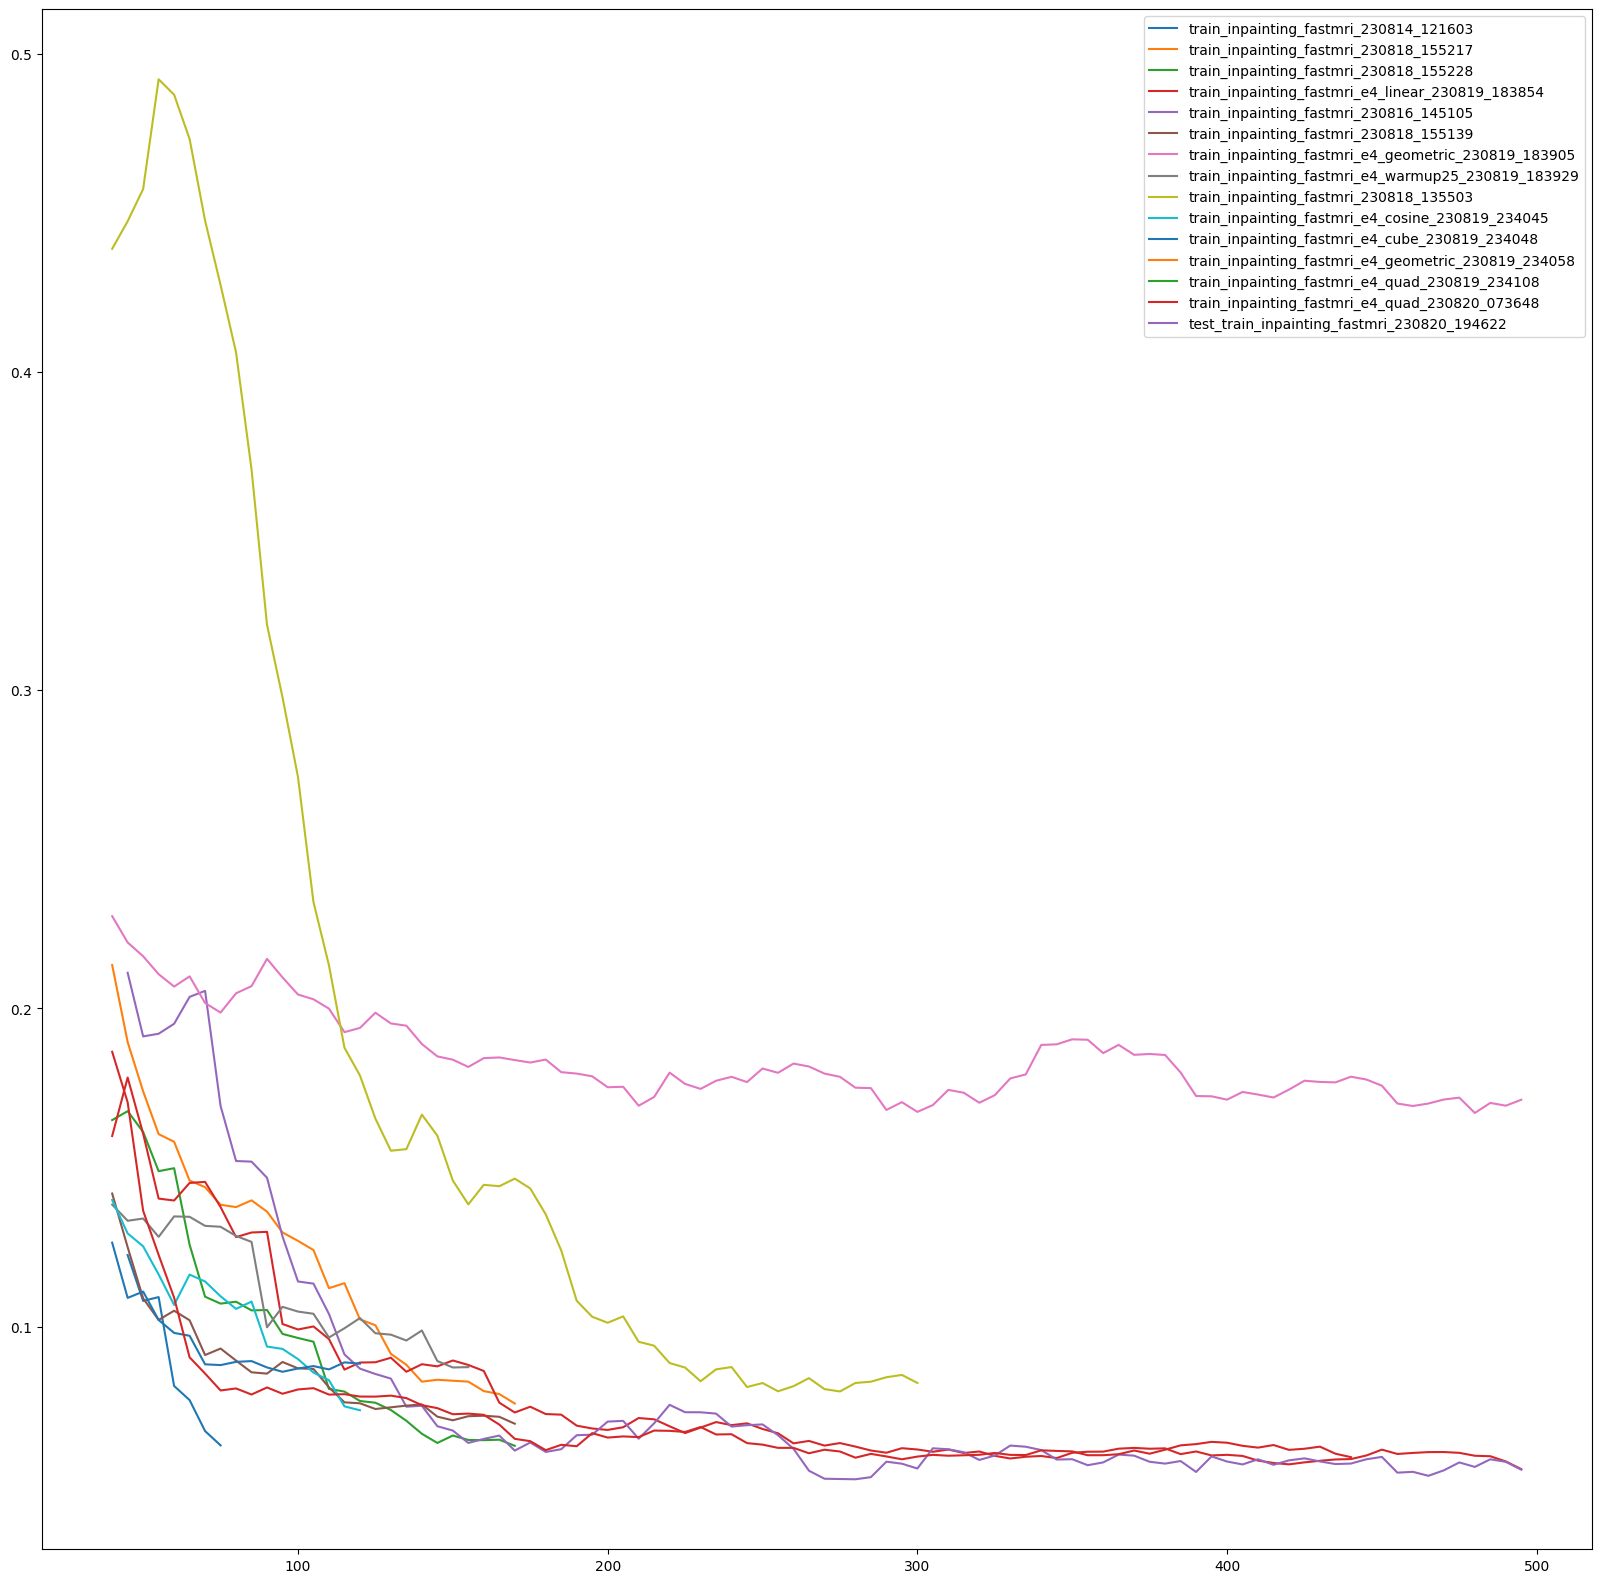

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
for ROOT in glob('experiments/*inpainting*'):
    ROOT = ROOT + '/results/val/'
    experiment = ROOT.split('/')[-4]
    folders = glob(f"{ROOT}/*")
    folders = sorted(folders, key=lambda f: int(f.split('/')[-1]))
    ret = {}
    for folder in folders:
        epoch = int(folder.split('/')[-1])
        pngs = [g for g in glob(f'{folder}/*') if any(x in g for x in ['GT', 'Out', 'Mask'])]
        slcs = set([p.split('/')[-1].replace('GT_','').replace('Out_','').replace('Mask_','') for p in pngs])
        slcs = {k:
            {'gt': [p for p in pngs if k in p and 'GT' in p][0],
            'out': [p for p in pngs if k in p and 'Out' in p][0],
            'mask': [p for p in pngs if k in p and 'Mask' in p][0]} for k in slcs}
        masked_loss = []
        loss = []
        for slc in slcs.values():
            gt_path = slc['gt']
            gt = Image.open(gt_path)
            gt_array = tx(gt)
            out_path = slc['out']
            out = Image.open(out_path)
            out_array = tx(out)
            mask_path = slc['mask']
            mask = Image.open(mask_path)
            mask_array = tx(mask) == 1
            masked_loss.append(torch.sum((gt_array - out_array) ** 2) / mask_array.sum())
            loss.append(l2(out_array, gt_array))
        ret[epoch] = {
            'masked_loss': torch.tensor(masked_loss).mean(),
            'loss': torch.tensor(loss).mean(),
        }
        # print(experiment, epoch, end='\r')

    ax.plot(ret.keys(), pd.Series([r['masked_loss'] for r in ret.values()]).rolling(window=SMOOTH).mean(), label=experiment)
    if ret:
        print(experiment, min([r['masked_loss'] for r in ret.values()]).item(), pd.Series([r['masked_loss'] for r in ret.values()]).rolling(window=SMOOTH).mean().min())
    # plt.plot(ret.keys(), [r['loss'] for r in ret.values()], label='masked_loss')
ax.legend()
plt.show()

In [33]:
ret

{}